In this notebook decriptive statistical data analysis is perfomred for the database. 

In [189]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import gensim

from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary


import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string
import gensim.corpora as corpora

from plotnine import ggplot, aes, geom_line
from gensim.models import CoherenceModel

import os
import pandas as pd
import numpy as np
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import gensim

from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary


import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

from plotnine import ggplot, aes, geom_line
from gensim.models import CoherenceModel
import spacy

import pandas as pd
import os

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet

In [96]:

def remove_stopwords(texts,language='NL',num_freq_stopwords=40,extrastopwords=[]):
    
    stop_words_extend = []
    occ,occ_speech = occurence(texts)
    occ_speech_rev = inverse_dict(occ_speech)
    for key in sorted(occ_speech_rev)[::-1][0:num_freq_stopwords]:
        for word in occ_speech_rev[key]:
            stop_words_extend.append(word)
    for word in extrastopwords:        
        stop_words_extend.append(word)
    
    if language=='NL':
        stop_words = stopwords.words('dutch')
        stop_words.extend(stop_words_extend)
    else:
        stop_words = stopwords.words('french')
        stop_words.extend(stop_words_extend)
    return [[word for word in doc 
             if word not in stop_words] for doc in texts]


def sent_to_words(sentences,min_len=2):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=min_len))    # min_len=2

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'], language='NL', notags=True):
    """https://spacy.io/api/annotation"""
    if language == 'NL':
        nlp = spacy.load("nl_core_news_md")
    elif language =='FR':
        nlp = spacy.load("fr_core_news_md")
        
    texts_out = []
    texts_out2 = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags or notags)])
        texts_out2.append([token.lemma_ for token in doc ])
    return texts_out,texts_out2

def occurence(texts):
    occ = {}  
    occ_speech = {}
    for speech in texts:
        for word in speech:
            occ[word] = occ.get(word, 0) + 1
        for word, count in occ.items():
            if word in speech:
                occ_speech[word] = occ_speech.get(word, 0) + 1
    return occ, occ_speech

def inverse_dict(input_dict):
    inverse = {}
    for key, value in input_dict.items():
        token = inverse.get(value, [])
        token.append(key)
        inverse[value] = token
        
    return inverse

def compute_coherence_values(dictionary, corpus, texts, limit=40, start=2, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=88)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score - LDA")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = Nmf(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=88)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score - NMF")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    

    return None



def removedwords(texts1,texts2):
    set1 = []
    set2 = []
    for text in texts1:
        for word in text:
            set1.append(word)
    for text in texts2:
        for word in text:
            set2.append(word)   
            
    set1 = set(set1)
    set2 = set(set2)
    print('the following tokens are removed')
    print(set1 - set2)
    return None

def pre_processing(speeches,input_type='filename', language='NL', 
                   min_len=2, lem=True, notags=False,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'],num_freq_stopwords=40,extrastopwords=[]):
    
    #The input is either a filename, or a dataframe serie
    if input_type=='filename':
        df = pd.read_csv(speeches)
        data = df['0']
    else:
        data = speeches
    original = data    
    #Remove punctuation 
    data = data.map(lambda x: re.sub('[,\\.!?]', '', x))
    
    #Convert the text to lowercase
    data = data.map(lambda x: x.lower())
    
    #text to words 
    data_words = data.map(lambda x: x.split())
    
    #lemmatize
    if lem:
        lemma = lemmatization(data_words, language=language, allowed_postags=allowed_postags, notags=notags)
        data_words_lemm = lemma[0]
    else:
        data_words_lemm = data_words
    
    #remove stopwords
    
    data_words_lemm_stopwordsremoved = remove_stopwords(data_words_lemm,language=language,num_freq_stopwords=num_freq_stopwords,extrastopwords=extrastopwords)    
    id2word = corpora.Dictionary(data_words_lemm_stopwordsremoved)
    corpus = [id2word.doc2bow(text) for text in data_words_lemm_stopwordsremoved]
    
    return id2word,corpus,data_words_lemm_stopwordsremoved,original,data_words_lemm,lemma[1]
        
def createmodels(id2word,corpus,num_topics=5):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics,random_state=88)
    nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=num_topics,random_state=88)
    
    tfidf = TfidfModel(dictionary=id2word)
    corpus_tfidf = list(tfidf[corpus])
    nmf_tfidf_model = Nmf(corpus=corpus_tfidf, id2word=id2word,num_topics=num_topics,random_state=88)
    
    return lda_model, nmf_model, nmf_tfidf_model

def overview(num_topics=10, num_freq_stopwords=40, language='NL', notags=False, min_len=2,filename='Dutch.csv',extrastopwords=[]):
    print(f"The number of topics is {num_topics}." )
    print(f"Tokens with the {num_freq_stopwords} highest document frequency are added to the stopwords and removed from the corpus.")
    print(f'All the selected tokens have a minimum length of {min_len}.')    
    data = pre_processing(filename,min_len=min_len,notags=True,extrastopwords=extrastopwords,language=language)    
    corpus = data[1]
    id2word = data[0] 
    input_tokens = data[2]
    texts = data[3]
    
    print('The descriptive statistics of the processed data is shown below.')
    descriptive_data(input_tokens, n1=num_freq_stopwords)
    
    removedwords(data[5],input_tokens)
    
    return None

def descriptive_data(df_input,n1=20):
    occ, occ_speech = occurence(df_input)
    occ_rev = inverse_dict(occ)
    occ_speech_rev = inverse_dict(occ_speech)
    
    print('The tokens with the highest document frequence are')
    for key in sorted(occ_speech_rev)[::-1][0:n1]:        
        print(occ_speech_rev[key])
        
    print('The tokens with the highest term frequence are')   
    for key in sorted(occ_rev)[::-1][0:n1]:        
        print(occ_rev[key])
    print('The descriptive statistics for the term frequence are presented below:')
    print(pd.DataFrame(list(occ.values())).describe())
    print('The descriptive statistics for the document frequence are presented below:')
    print(pd.DataFrame(list(occ_speech.values())).describe())
    
    return None 

In [195]:
def readdata(filename,language='NL'):
    NL = pd.read_csv(filename)
    # Remove punctuation
    NL['text_processed'] = NL['0'].map(lambda x: re.sub('[,\\.!?]', '', x))
    # Convert the titles to lowercase
    NL['text_processed'] = NL['text_processed'].map(lambda x: x.lower())
    # Print out the first rows 
    NL['text_word'] = NL['text_processed'].map(lambda x: x.split())
    NL['text_length'] = NL['text_processed'].map(lambda x: len(x.split()))
    NL['word_lem'] = lemmatization(NL['text_word'], notags=True,language=language)[0]
    NL['text_length_lem'] = NL['word_lem'].map(lambda x: len(x))
    NL['word_uni'] = NL['text_word'].map(lambda x:set(x))
    
    return NL

def format_topics_sentences(model, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = sent_topics_df.reset_index()
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    return(sent_topics_df)

def plotwordcloud(model):
    for t in range(model.num_topics):
        plt.figure()
        word_freq = {}
        for word in model.show_topic(t, 100):
            word_freq[word[0]] = word[1]

        plt.imshow(WordCloud(background_color='white').fit_words(word_freq))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()
    return None



def plotbar(model,texts):


    num_topics = model.num_topics
    topics = model.show_topics(formatted=False,num_topics=num_topics)
    data_ready = texts
    data_flat = [w for w_list in data_ready for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    plotsize = num_topics//2
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(plotsize, 2, figsize=(num_topics,num_topics*2), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i%10])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100)
        ax.set_title('Topic: ' + str(i), color=cols[i%10], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()
    
    return None


def plottopicdocument(model,corpus):
    dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            
    # Distribution of Dominant Topics in Each Document
    df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
    dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
    df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

    # Total Topic Distribution by actual weight
    topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

    # Top 3 Keywords for each Topic
    num_topics = model.num_topics
    topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False,num_topics=num_topics) 
                                     for j, (topic, wt) in enumerate(topics) if j < 3]

    df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
    df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
    df_top3words.reset_index(level=0,inplace=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(num_topics*2.5, 10), dpi=240, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=25))
    ax1.set_ylabel('Number of Documents')
    

    # Topic Distribution by Topic Weights
    ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
    ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
    ax2.xaxis.set_major_formatter(tick_formatter)
    ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=25))
    
    return None 
    
    
def plottsne(model,corpus):

    # Get topic weights
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0]*num_topics
        for j,p in row_list:
            tw[j] = p
        topic_weights.append(tw)

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    #arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)


    # Plot the Topic Clusters using Bokeh
    output_notebook()
    n_topics = num_topics
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} Topics".format(n_topics), 
                  plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num%10])
    

    source = ColumnDataSource(data=dict(
        x=tsne_lda[:,0],
        y=tsne_lda[:,1],
        names=list(range(108))))
    
    



    labels = LabelSet(x='x', y='y', text='names', 
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    plot.add_layout(labels)
    show(plot)
    
    return None 

In [201]:
plottsne(models_fr[0],corpus_fr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.686211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.439224
[t-SNE] KL divergence after 1000 iterations: 0.113499


Loading BokehJS ...

In [196]:
plottsne(models[0],corpus)




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.713197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.843735
[t-SNE] KL divergence after 800 iterations: 0.103143


Loading BokehJS ...

In [198]:
plottsne(models2[0],corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.670398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.340916
[t-SNE] KL divergence after 1000 iterations: 0.057784


Loading BokehJS ...

In [182]:
np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], dtype='<U7')

In [32]:
NL = readdata('Dutch.csv',language='NL')
FR = readdata('French.csv',language='FR')

In [42]:
#output for table 1 of the note
print('number of texts')
print(len(FR['0']))
print(len(NL['0']))

print('Nr of tokens')
n_t_f = 0
n_t_n = 0
for text in NL['text_word']:
    n_t_n += len(text)
for text in FR['text_word']:
    n_t_f += len(text)
    
print(n_t_f)
print(n_t_n)
print('Nr of unique tokens')

nederlands = []
french =[]

for text in NL['text_word']:
    for word in text:
        nederlands.append(word)
for text in FR['text_word']:
    for word in text:
        french.append(word)
        
print(len(set(french)))
        
print(len(set(nederlands)))

number of texts
108
108
Nr of tokens
39282
34983
Nr of unique tokens
5568
4681


In [48]:
#output for table 2
table2 = pd.DataFrame()
table2['d1'] = NL['text_length'].describe()
table2['f1'] = FR['text_length'].describe()
table2['d2'] = NL['text_processed'].map(lambda x: len(set(x.split()))).describe()
table2['f2'] = FR['text_processed'].map(lambda x: len(set(x.split()))).describe()
print(table2)

                d1           f1          d2          f2
count   108.000000   108.000000  108.000000  108.000000
mean    323.916667   363.722222  157.333333  186.620370
std     246.286101   253.861204   83.949584   96.183792
min      15.000000    41.000000   14.000000   32.000000
25%     174.000000   204.250000  105.500000  125.500000
50%     273.500000   329.500000  147.000000  184.500000
75%     390.250000   436.250000  183.500000  226.500000
max    1734.000000  1547.000000  558.000000  579.000000


The frequency of each word/token


Text(0, 0.5, 'Number of tokens in one speech')

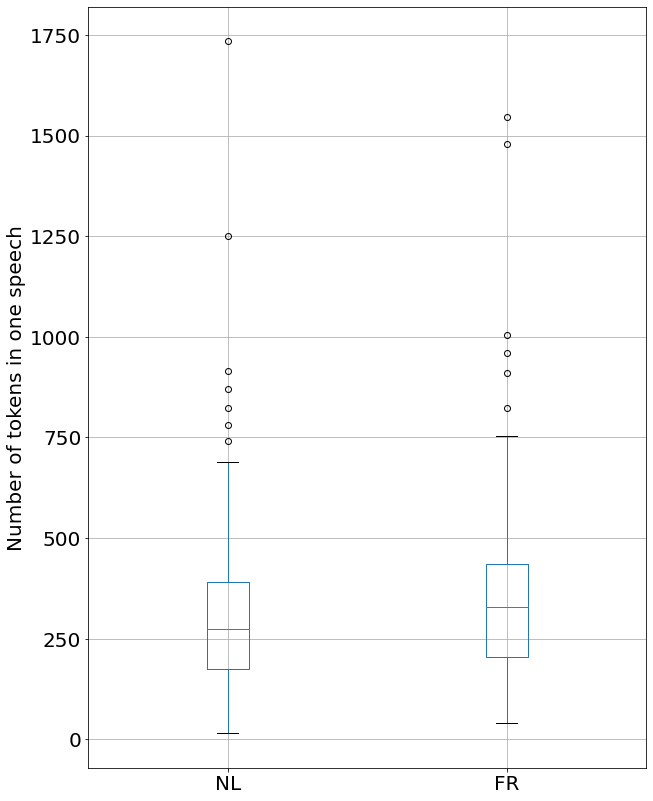

In [52]:
text_length = pd.DataFrame(columns=['NL', 'FR'])
text_length['NL'] = NL['text_length']
text_length['FR'] = FR['text_length']
text_length['NL_uni'] = NL['word_uni'].map(lambda x:len(x))
text_length['FR_uni'] = FR['word_uni'].map(lambda x:len(x))
text_length['NL_lem'] = NL['text_length_lem']
text_length['FR_lem'] = FR['text_length_lem']
boxplot = text_length.boxplot(column=['NL','FR'], figsize=(10,14), fontsize=20)
boxplot.set_ylabel('Number of tokens in one speech',fontsize=20)

    

Text(0, 0.5, 'Number of tokens in one speech')

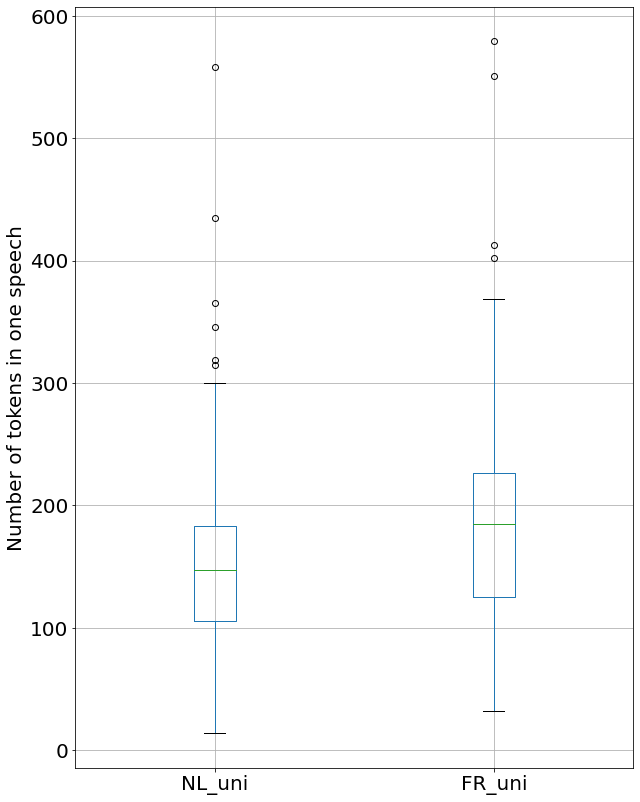

In [51]:
boxplot2 = text_length.boxplot(column=['NL_uni','FR_uni'], figsize=(10,14), fontsize=20)
boxplot2.set_ylabel('Number of tokens in one speech',fontsize=20)
        
     

In [53]:
occ, occ_speech = occurence(NL['text_word'])
occ_lem, occ_speech_lem = occurence(NL['word_lem'])
occ_speech_lem_rev = inverse_dict(occ_speech_lem)
occ_speech_rev = inverse_dict(occ_speech)
occ_fr, occ_speech_fr = occurence(FR['text_word'])
occ_lem_fr, occ_speech_lem_fr = occurence(FR['word_lem'])
occ_speech_lem_rev_fr = inverse_dict(occ_speech_lem_fr)
occ_speech_rev_fr = inverse_dict(occ_speech_fr)

print(pd.DataFrame(list(occ.values())).describe())
print(pd.DataFrame(list(occ_speech.values())).describe())
print(pd.DataFrame(list(occ_fr.values())).describe())
print(pd.DataFrame(list(occ_speech_fr.values())).describe())

In [60]:
pd.DataFrame(list(occ.values())).describe()

0
count  4681.000000
mean      7.473403
std      57.417661
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max    2233.000000

In [64]:

table3 = pd.DataFrame()
table3['d1'] = pd.DataFrame(list(occ.values())).describe()[0]
table3['f1'] = pd.DataFrame(list(occ_fr.values())).describe()[0]
table3['d2'] = pd.DataFrame(list(occ_speech.values())).describe()[0]
table3['f2'] = pd.DataFrame(list(occ_speech_fr.values())).describe()[0]
table3['d3'] = pd.DataFrame(list(occ_lem.values())).describe()[0]
table3['f3'] = pd.DataFrame(list(occ_lem_fr.values())).describe()[0]
table3['d4'] = pd.DataFrame(list(occ_speech_lem.values())).describe()[0]
table3['f4'] = pd.DataFrame(list(occ_speech_lem_fr.values())).describe()[0]


print(table3)

                d1           f1           d2           f2           d3  \
count  4681.000000  5568.000000  4681.000000  5568.000000  3817.000000   
mean      7.473403     7.054957     3.629994     3.619792     9.165575   
std      57.417661    48.218537     9.231602     9.001508    64.150568   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       1.000000     1.000000     1.000000     1.000000     1.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       3.000000     3.000000     3.000000     3.000000     4.000000   
max    2233.000000  1915.000000   108.000000   107.000000  2241.000000   

                f3           d4           f4  
count  3890.000000  3817.000000  3890.000000  
mean     10.834190     4.242861     4.626992  
std      87.590024    10.464674    10.630929  
min       1.000000     1.000000     1.000000  
25%       1.000000     1.000000     1.000000  
50%       2.000000     1.000000     1.000000  
75% 

In [65]:
for key in sorted(occ_speech_lem_rev)[::-1][0:40]:
    print(occ_speech_lem_rev[key])
    

['de']
['het']
['van']
['een']
['dat', 'euh']
['en']
['is']
['we']
['niet', 'in']
['die']
['te']
['zijn', 'voor']
['er']
['ik', 'op']
['worden']
['hebben']
['met', 'ook', 'u', 'maar']
['moeten']
['om']
['voorzitter', 'aan', 'dan']
['zullen']
['als']
['willen']
['dit', 'moet', 'dus', 'wel']
['over', 'kunnen']
['gaan', 'wat']
['heeft']
['goed']
['tot', 'europees', 'wij']
['zeggen']
['deze']
['meer', 'daar', 'dank']
['commissie']
['al', 'zo', 'want', 'nu']
['onze']
['komen']
['maken']
['nog']
['door', 'heel', 'één']
['parlement', 'kan']


In [66]:

for key in sorted(occ_speech_lem_rev_fr)[::-1][0:40]:
    print(occ_speech_lem_rev_fr[key])
    

['le', "'"]
['être', 'de']
['un']
['l', 'que']
['en', 'et', 'à']
['avoir']
['je', 'il']
['d', 'ce']
['pas']
['pour']
['sur']
['Monsieur', 'qui', 'dans']
['président']
['nous']
['ne', 'européen']
['c', 'au', 'mais']
['notre']
['qu']
['tout']
['par']
['n']
['son']
['faire']
['devoir', 's', 'pouvoir']
['plus']
['euh']
['commission', 'avec']
['vous', 'lui', '-']
['y', 'bien']
['comme', 'même', 'merci', 'deux']
['se']
['on', 'mon', 'collègue', 'dire']
['parlement']
['union']
['vouloir']
['falloir']
['ou']
['cela']
['europe', 'donc', 'si']
['politique', 'aller']


In the original dataset, a space is present after each '''. 

In [34]:
description = pd.DataFrame(columns=['NL', 'FR'])
description['NL'] = text_length['NL'].describe()
description['FR'] = text_length['FR'].describe()
description['NL_uni'] = text_length['NL_uni'].describe()
description['FR_uni'] = text_length['FR_uni'].describe()
description['FR_lem'] = text_length['FR_lem'].describe()
description['NL_lem'] = text_length['NL_lem'].describe()
print(description)

                NL           FR      NL_uni      FR_uni       FR_lem  \
count   108.000000   108.000000  108.000000  108.000000   108.000000   
mean    323.916667   363.722222  157.333333  186.620370   390.231481   
std     246.286101   253.861204   83.949584   96.183792   273.749036   
min      15.000000    41.000000   14.000000   32.000000    42.000000   
25%     174.000000   204.250000  105.500000  125.500000   218.250000   
50%     273.500000   329.500000  147.000000  184.500000   357.000000   
75%     390.250000   436.250000  183.500000  226.500000   464.500000   
max    1734.000000  1547.000000  558.000000  579.000000  1718.000000   

            NL_lem  
count   108.000000  
mean    323.935185  
std     246.287586  
min      15.000000  
25%     174.000000  
50%     273.500000  
75%     390.250000  
max    1734.000000  


Text(0.5, 0, 'NL')

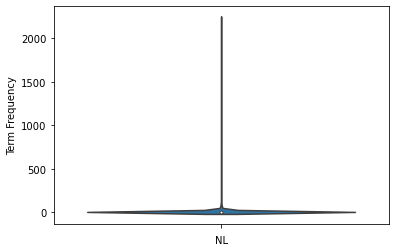

In [69]:
p = sns.violinplot(y=list(occ.values()))
p.set_ylabel('Term Frequency')
p.set_xlabel('NL')

Text(0.5, 0, 'FR')

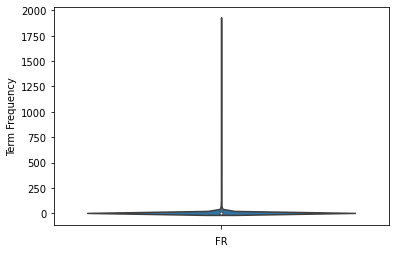

In [70]:
p = sns.violinplot(y=list(occ_fr.values()))
p.set_ylabel('Term Frequency')
p.set_xlabel('FR')

Text(0.5, 0, 'NL')

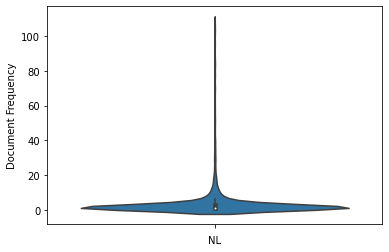

In [71]:
p = sns.violinplot(y=list(occ_speech.values()))
p.set_ylabel('Document Frequency')
p.set_xlabel('NL')

Text(0.5, 0, 'FR')

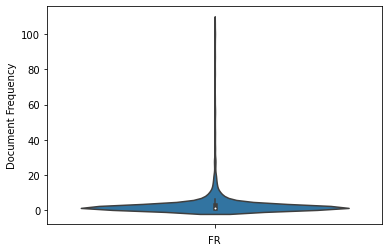

In [66]:
p = sns.violinplot(y=list(occ_speech_fr.values()))
p.set_ylabel('Document Frequency')
p.set_xlabel('FR')

In [270]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.004864  0.034320       1        1  16.863308
6     -0.014279  0.005711       2        1  15.854448
3     -0.001836 -0.008194       3        1  14.202040
4     -0.066545 -0.008040       4        1  11.364105
5      0.004262  0.028244       5        1   9.571412
7      0.014106  0.029558       6        1   8.404333
0     -0.000076 -0.032790       7        1   6.261820
2      0.014672 -0.005271       8        1   6.150395
8      0.026937 -0.035254       9        1   5.785352
1      0.017894 -0.008286      10        1   5.542787, topic_info=            Term       Freq      Total Category  logprob  loglift
561    onderzoek  32.000000  32.000000  Default  30.0000  30.0000
148       europa  50.000000  50.000000  Default  29.0000  29.0000
127        vrouw  11.000000  11.000000  Default  28.0000  28.0000
453         twee  59.000000  59.000000  Default  27.0000  27.0000
302       gebied  21.000000  21.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
471         zien   2.138694  47.742512  Topic10  -5.7817  -0.2130
415        nieuw   1.970761  38.627332  Topic10  -5.8634  -0.0829
295        ander   2.005901  41.726076  Topic10  -5.8458  -0.1424
503  tweeduizend   1.783951  31.402973  Topic10  -5.9630   0.0246
88    rapporteur   1.783924  33.871831  Topic10  -5.9630  -0.0511

[754 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
640       2  0.612425   aankomen
641       2  0.613851   aankomst
21        1  0.120239  aanpassen
21        2  0.120239  aanpassen
21        3  0.120239  aanpassen
...     ...       ...        ...
234       7  0.036842     zorgen
234       8  0.036842     zorgen
234       9  0.073683     zorgen
234      10  0.036842     zorgen
1757      5  0.415916     zozeer

[1808 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 4, 5, 6, 8, 1, 3, 9, 2])

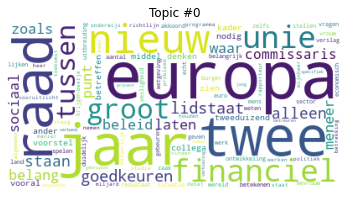

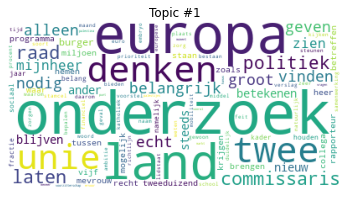

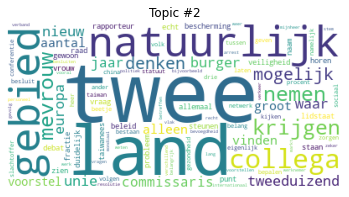

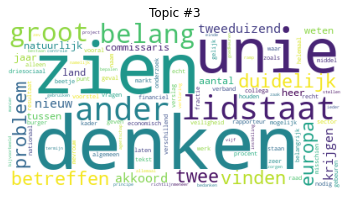

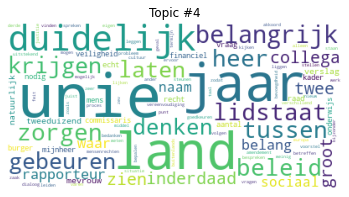

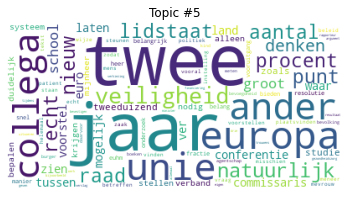

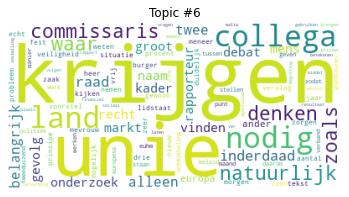

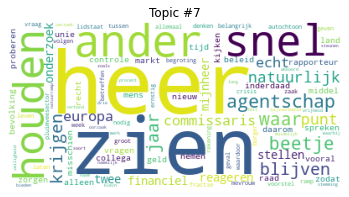

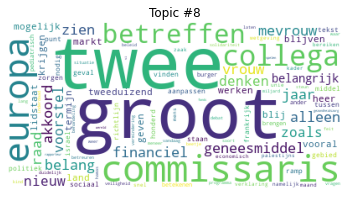

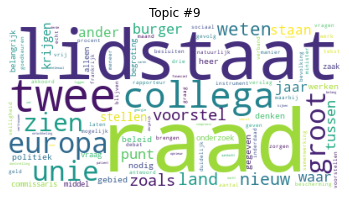

In [186]:
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    word_freq = {}
    for word in lda_model.show_topic(t, 100):
        word_freq[word[0]] = word[1]
    
    plt.imshow(WordCloud(background_color='white').fit_words(word_freq))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

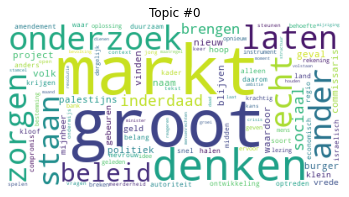

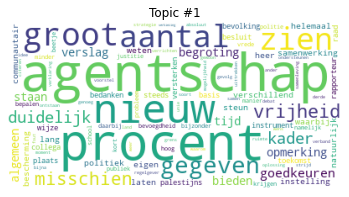

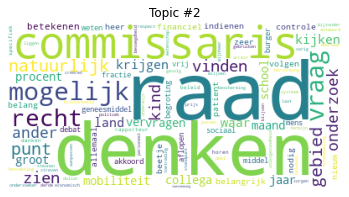

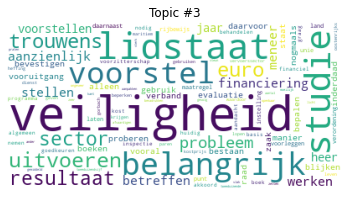

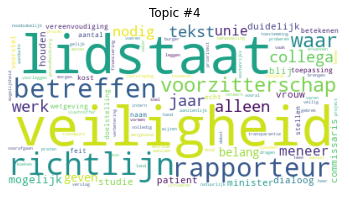

In [118]:
for t in range(models[1].num_topics):
    plt.figure()
    word_freq = {}
    for word in models[1].show_topic(t, 100):
        word_freq[word[0]] = word[1]
    
    plt.imshow(WordCloud(background_color='white').fit_words(word_freq))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [176]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9922   
1        1.0              0.9946   
2        2.0              0.9941   
3        3.0              0.9960   
4        4.0              0.9938   
5        5.0              0.9967   
6        6.0              0.9945   
7        7.0              0.9957   
8        8.0              0.9958   
9        9.0              0.9963   

                                            Keywords  \
0  europa, jaar, twee, raad, nieuw, financiel, un...   
1  onderzoek, europa, land, denken, twee, unie, c...   
2  twee, land, natuurlijk, gebied, collega, krijg...   
3  denken, zien, unie, lidstaat, ander, belang, g...   
4  unie, jaar, land, duidelijk, belangrijk, zorge...   
5  twee, jaar, europa, unie, ander, collega, veil...   
6  krijgen, unie, collega, nodig, land, commissar...   
7  heer, zien, ander, snel, houden, agentschap, w...   
8  twee, groot, commissaris, europa, collega, bet...   
9  raad, lidstaat, twee, collega, europa, unie, g...   

                                                Text  
0  mevrouw de commissaris ik zou vooreerst op mij...  
1  hm u de beslissing die u nu genomen heeft ik h...  
2  dank u wel meneer de voorzitter mevrouw de com...  
3  voorzitter een opmerking vooraf als het mag wa...  
4  dank u wel voorzitter ik wil de heer Gargani d...  
5  dankjewel mevrouw de voorzitter dankjewel comm...  
6  dank u voorzitter . inderdaad bij het bezoek v...  
7  voorzitter geachte commissaris het toetredings...  
8  voorzitter de xxx euh geachte werd euh honderd...  
9  dank u voorzitter mag ik u feliciteren met uw ...

In [177]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0.0               3.0  denken, zien, unie, lidstaat, ander, belang, g...   
1.0               3.0  denken, zien, unie, lidstaat, ander, belang, g...   
2.0               5.0  twee, jaar, europa, unie, ander, collega, veil...   
3.0               3.0  denken, zien, unie, lidstaat, ander, belang, g...   
4.0               4.0  unie, jaar, land, duidelijk, belangrijk, zorge...   
...               ...                                                ...   
103.0             4.0  unie, jaar, land, duidelijk, belangrijk, zorge...   
104.0             8.0  twee, groot, commissaris, europa, collega, bet...   
105.0             6.0  krijgen, unie, collega, nodig, land, commissar...   
106.0             6.0  krijgen, unie, collega, nodig, land, commissar...   
107.0             0.0  europa, jaar, twee, raad, nieuw, financiel, un...   

       Num_Documents  Perc_Documents  
0.0              8.0          0.0741  
1.0              5.0          0.0463  
2.0              9.0          0.0833  
3.0             14.0          0.1296  
4.0             15.0          0.1389  
...              ...             ...  
103.0            NaN             NaN  
104.0            NaN             NaN  
105.0            NaN             NaN  
106.0            NaN             NaN  
107.0            NaN             NaN  

[108 rows x 4 columns]

In [146]:
df_topic_sents_keywords['Dominant_Topic']

0      2.0
1      6.0
2      5.0
3      7.0
4      5.0
      ... 
103    8.0
104    9.0
105    9.0
106    7.0
107    3.0
Name: Dominant_Topic, Length: 108, dtype: float64

In [151]:
data[3][0]

'sorry voorzitter ik weet niet op basis van welk artikel ik dit moet doen . al een e paar stemmingen is dat zo dat ik een probleem heb euh met het euh Franse vertaling want ... e onthouding en tegenstemmen wordt euh verward . onthouding en tegenstemmen dat wordt door mekaar gehaald . dat wilde ik melden en daarom moesten we ook euh liever niet wachten tot het einde van de stemming .'

In [148]:
model

7.0    0.1852
8.0    0.1296
6.0    0.1296
2.0    0.1204
4.0    0.1019
3.0    0.1019
5.0    0.0833
9.0    0.0648
0.0    0.0556
1.0    0.0278
Name: Dominant_Topic, dtype: float64

In [149]:
topic_num_keywords

Dominant_Topic                                     Topic_Keywords
0               2.0  verkeerd, humanitair, geschiedenis, vereenvoud...
1               6.0  palestijns, israelisch, krachtig, werknemer, m...
2               5.0  school, wetenschap, nogmaals, niveau, uitvoere...
3               7.0  agentschap, rechterlijk, buitenlands, intercul...
4               5.0  school, wetenschap, nogmaals, niveau, uitvoere...
..              ...                                                ...
103             8.0  financiel, agentschap, dollar, winst, weddensc...
104             9.0  financiel, bank, bestemming, patient, breken, ...
105             9.0  financiel, bank, bestemming, patient, breken, ...
106             7.0  agentschap, rechterlijk, buitenlands, intercul...
107             3.0  taal, trans, nogmaals, luchtvaart, uitvoeren, ...

[108 rows x 2 columns]

In [154]:
df_topic_sents_keywords

Dominant_Topic  Perc_Contribution  \
0               5.0             0.9000   
1               1.0             0.9795   
2               2.0             0.9308   
3               1.0             0.8875   
4               6.0             0.9526   
..              ...                ...   
103             1.0             0.9690   
104             4.0             0.9526   
105             4.0             0.9887   
106             6.0             0.9500   
107             8.0             0.9743   

                                        Topic_Keywords  \
0    patient, delegatie, gegeven, toestemming, uitv...   
1    financiel, paragraaf, ondervragen, inhoud, dis...   
2    dringend, live, referendum, slapen, premier, c...   
3    financiel, paragraaf, ondervragen, inhoud, dis...   
4    agentschap, discussie, oplossen, ethisch, kade...   
..                                                 ...   
103  financiel, paragraaf, ondervragen, inhoud, dis...   
104  financiel, uitvoeren, vermindering, pediatrisc...   
105  financiel, uitvoeren, vermindering, pediatrisc...   
106  agentschap, discussie, oplossen, ethisch, kade...   
107  school, agentschap, vereenvoudiging, taal, tra...   

                                                     0  
0    sorry voorzitter ik weet niet op basis van wel...  
1    mevrouw de commissaris meneer de voorzitter co...  
2    mevrouw de commissaris voorzitter het is een d...  
3    het algemene euh reglement . ik zou willen wet...  
4    dank u voorzitter ik wil mevrouw Járóka bedank...  
..                                                 ...  
103  voorzitter meneer de Premier ik wil de heer Ve...  
104  dank u wel Voorzitter Commissaris collega's de...  
105  dank u wel mevrouw de Voorzitter Commissaris c...  
106  de euh EU en de VS moeten de dialoog op het ha...  
107  dank u wel Voorzitter in het kader van de tran...  

[108 rows x 4 columns]

In [164]:
sent_topics_outdf_grpd.head()

Dominant_Topic  Perc_Contribution  \
0              2.0             1.0000   
1              6.0             0.6709   
2              5.0             0.4889   
3              7.0             0.4118   
4              5.0             0.4833   
5              2.0             0.4733   
6              7.0             0.4635   
7              6.0             0.4806   
8              3.0             0.7695   
9              6.0             0.6744   
10             6.0             0.7404   
11             9.0             0.4758   
12             3.0             0.5050   
13             7.0             0.6371   
14             0.0             0.4624   
15             2.0             0.5127   
16             6.0             0.5710   
18             0.0             1.0000   
19             4.0             0.3399   
20             9.0             0.5524   
22             2.0             0.2513   
24             7.0             0.8431   
26             7.0             0.4595   
27             9.0             1.0000   
28             1.0             0.4977   
29             3.0             0.8023   
30             8.0             0.4243   
32             2.0             0.4345   
34             8.0             0.6449   
37             5.0             0.4728   
38             3.0             0.4240   
39             4.0             0.5601   
40             3.0             0.4361   
41             5.0             0.7221   
42             8.0             0.2752   
45             5.0             0.4998   
47             4.0             0.6710   
48             4.0             0.5750   
50             8.0             0.5000   
51             4.0             0.5033   
60             8.0             0.3757   
75             0.0             0.4827   
76             0.0             0.7669   
77             1.0             0.4768   
79             1.0             0.6716   
80             9.0             0.5176   
81             9.0             0.7744   
83             0.0             1.0000   

                                       Topic_Keywords  \
0   verkeerd, humanitair, geschiedenis, vereenvoud...   
1   palestijns, israelisch, krachtig, werknemer, m...   
2   school, wetenschap, nogmaals, niveau, uitvoere...   
3   agentschap, rechterlijk, buitenlands, intercul...   
4   school, wetenschap, nogmaals, niveau, uitvoere...   
5   verkeerd, humanitair, geschiedenis, vereenvoud...   
6   agentschap, rechterlijk, buitenlands, intercul...   
7   palestijns, israelisch, krachtig, werknemer, m...   
8   taal, trans, nogmaals, luchtvaart, uitvoeren, ...   
9   palestijns, israelisch, krachtig, werknemer, m...   
10  palestijns, israelisch, krachtig, werknemer, m...   
11  financiel, bank, bestemming, patient, breken, ...   
12  taal, trans, nogmaals, luchtvaart, uitvoeren, ...   
13  agentschap, rechterlijk, buitenlands, intercul...   
14  school, leerling, vereenvoudiging, ondervragen...   
15  verkeerd, humanitair, geschiedenis, vereenvoud...   
16  palestijns, israelisch, krachtig, werknemer, m...   
18  school, leerling, vereenvoudiging, ondervragen...   
19  gegeven, politie, schenden, palestijns, rappor...   
20  financiel, bank, bestemming, patient, breken, ...   
22  verkeerd, humanitair, geschiedenis, vereenvoud...   
24  agentschap, rechterlijk, buitenlands, intercul...   
26  agentschap, rechterlijk, buitenlands, intercul...   
27  financiel, bank, bestemming, patient, breken, ...   
28  uitvoeren, patient, agentschap, toestemming, g...   
29  taal, trans, nogmaals, luchtvaart, uitvoeren, ...   
30  financiel, agentschap, dollar, winst, weddensc...   
32  verkeerd, humanitair, geschiedenis, vereenvoud...   
34  financiel, agentschap, dollar, winst, weddensc...   
37  school, wetenschap, nogmaals, niveau, uitvoere...   
38  taal, trans, nogmaals, luchtvaart, uitvoeren, ...   
39  gegeven, politie, schenden, palestijns, rappor...   
40  taal, trans, nogmaals, luchtvaart, uitvoeren, ...   
41  school, wetenschap, nogmaals, niveau, uitvoere...   

In [225]:
a = sorted(lda_model.show_topic(3,3322),key=lambda x: (x[0]), reverse=False)

In [246]:
X = []
for t in range(lda_model.num_topics):
    X.append([word[1] for word in sorted(lda_model.show_topic(3,3322),key=lambda x: (x[0]), reverse=False)])
    

In [113]:
lda_model.num_topics

12

In [112]:
lda_model.show_topics(num_topics=12)

[(0,
  '0.010*"onderzoek" + 0.005*"inderdaad" + 0.005*"naam" + 0.004*"bevolking" + 0.004*"zitten" + 0.004*"agentschap" + 0.003*"gebied" + 0.003*"steun" + 0.003*"xxx" + 0.003*"belang"'),
 (1,
  '0.005*"sociaal" + 0.005*"xxx" + 0.004*"recht" + 0.004*"markt" + 0.004*"richtlijn" + 0.004*"staan" + 0.004*"debat" + 0.003*"nou" + 0.003*"vrouw" + 0.003*"verband"'),
 (2,
  '0.005*"onderzoek" + 0.004*"akkoord" + 0.004*"snel" + 0.004*"betreffen" + 0.004*"politiek" + 0.003*"bieden" + 0.003*"blijven" + 0.003*"reageren" + 0.003*"werken" + 0.003*"geven"'),
 (3,
  '0.009*"sociaal" + 0.006*"vereenvoudiging" + 0.004*"staan" + 0.004*"situatie" + 0.004*"werknemer" + 0.004*"amendement" + 0.004*"gebeuren" + 0.004*"beleid" + 0.003*"frankrijk" + 0.003*"kijken"'),
 (4,
  '0.006*"mens" + 0.005*"beleid" + 0.004*"recht" + 0.004*"veiligheid" + 0.004*"akkoord" + 0.004*"inderdaad" + 0.004*"geven" + 0.004*"instrument" + 0.003*"staat" + 0.003*"staan"'),
 (5,
  '0.007*"vrouw" + 0.004*"geven" + 0.004*"besluiten" + 0.004*

In [119]:
len(out)

120

In [122]:
11%10

1

In [256]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(a)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

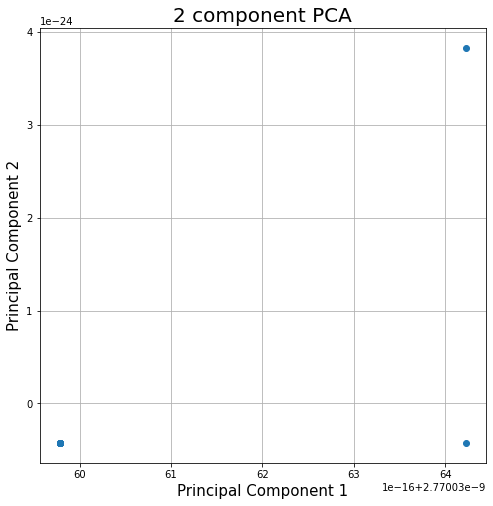

In [261]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1']
               , principalDf['principal component 2']
               )




ax.grid()

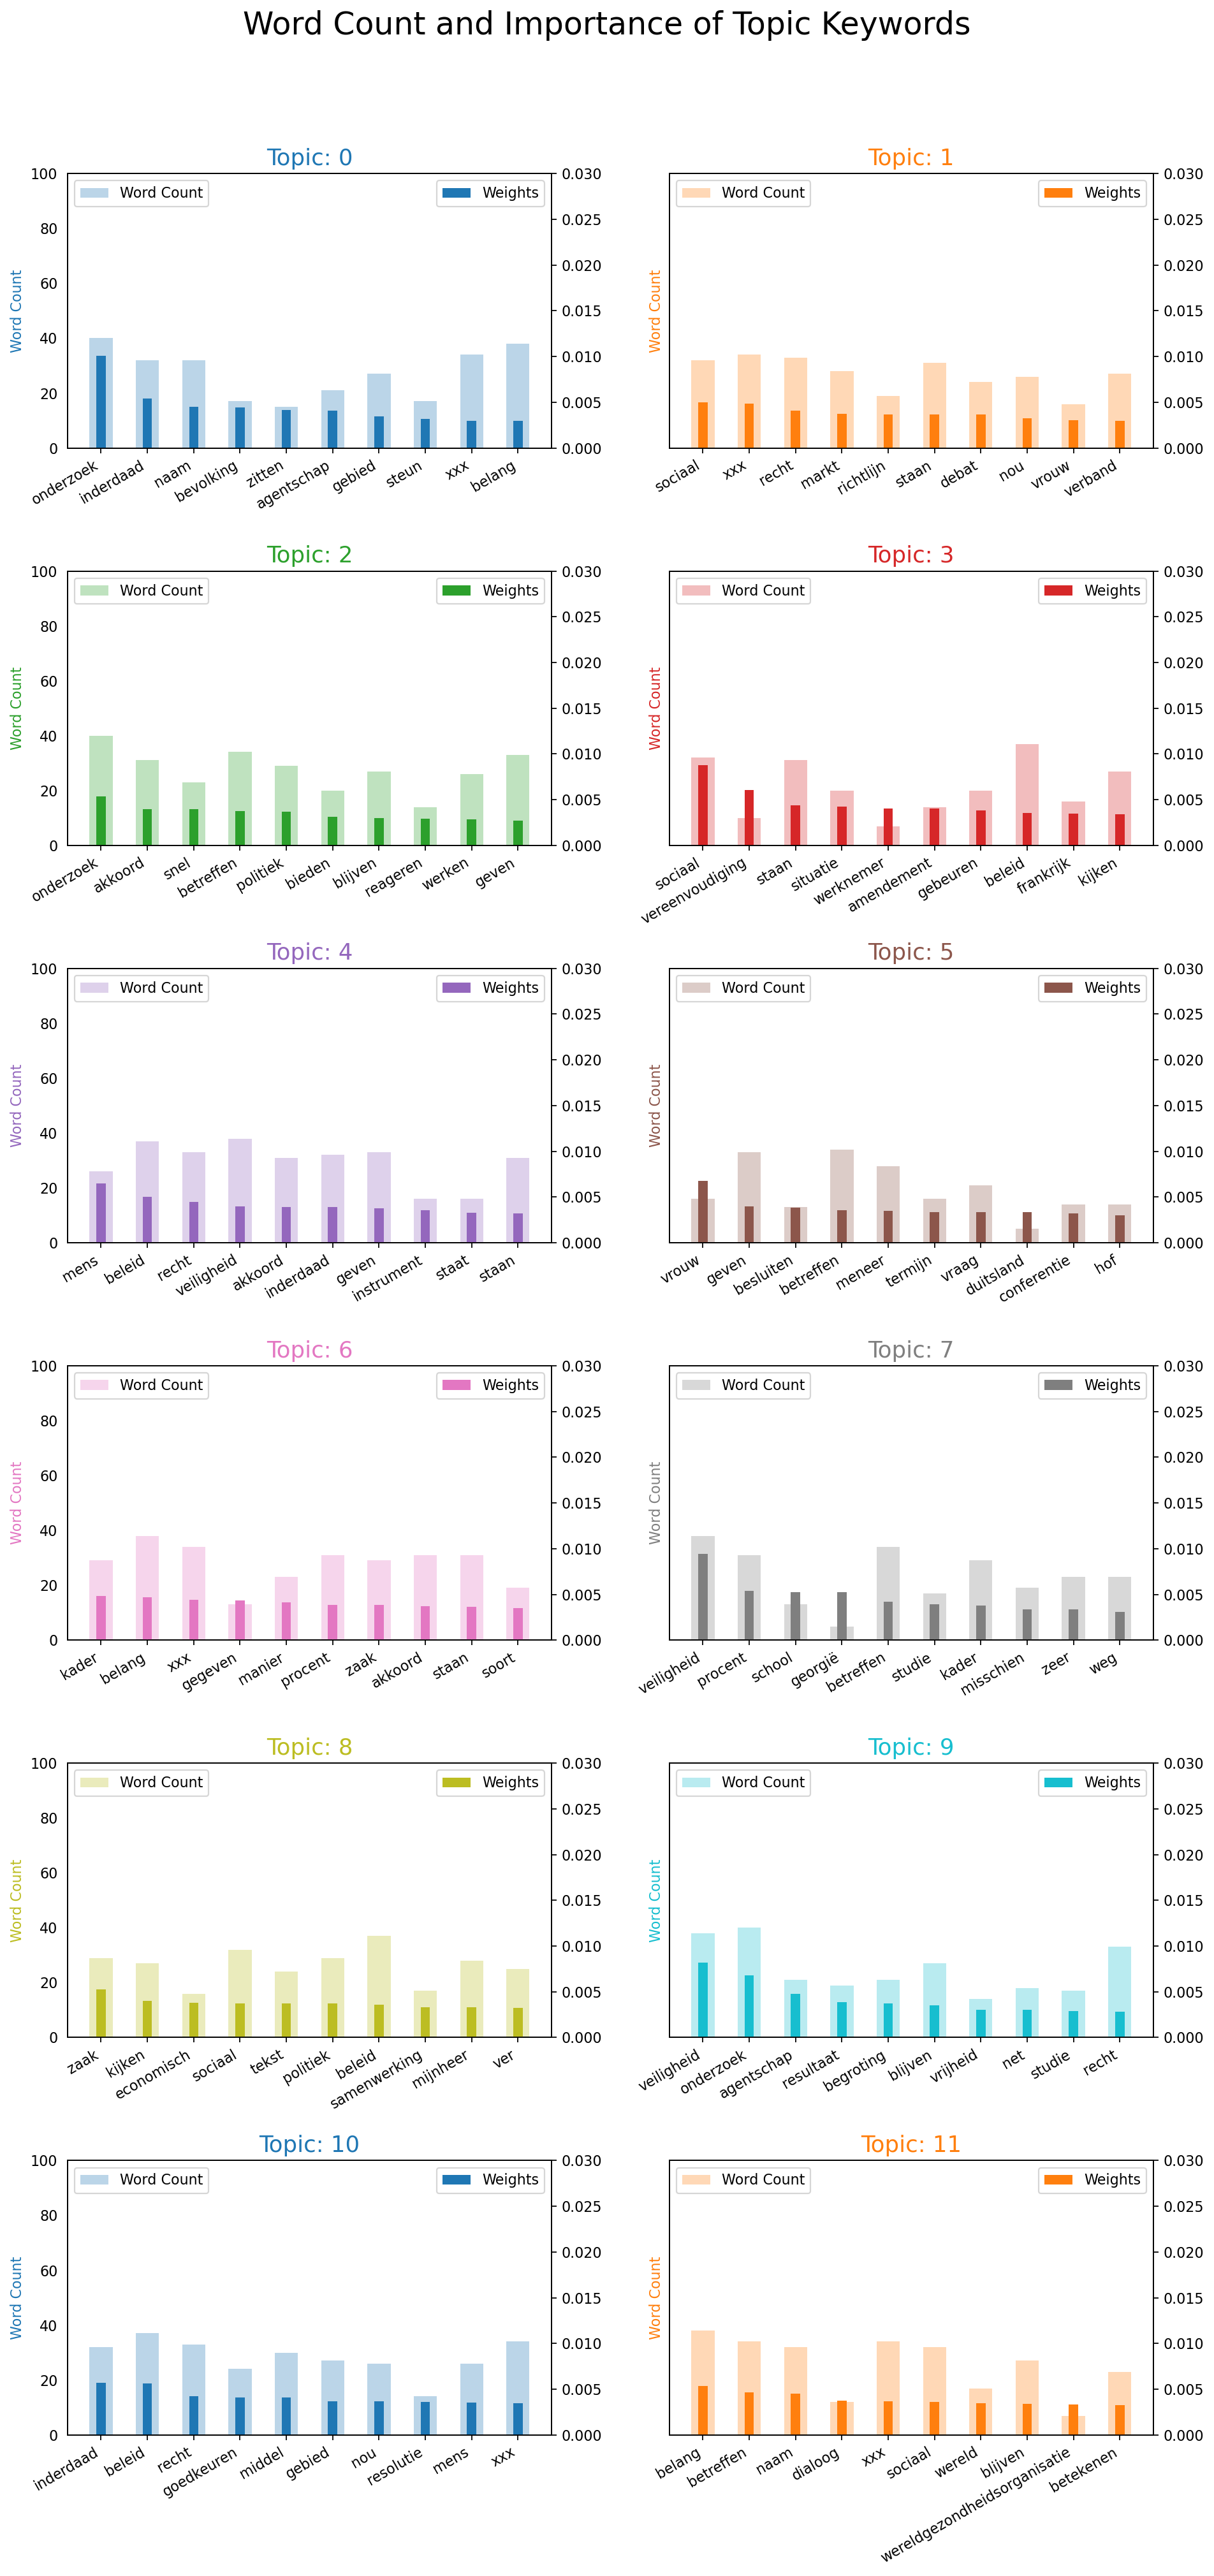

In [135]:
#ou want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.
from collections import Counter
num_topics = models[0].num_topics
topics = models[0].show_topics(formatted=False,num_topics=num_topics)
data_ready = data[2]
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

plotsize = num_topics//2
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(plotsize, 2, figsize=(num_topics,num_topics*2), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i%10])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100)
    ax.set_title('Topic: ' + str(i), color=cols[i%10], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [170]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return dominant_topics,topic_percentages




def plottopicdocument(model,corpus):
    dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            
    # Distribution of Dominant Topics in Each Document
    df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
    dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
    df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

    # Total Topic Distribution by actual weight
    topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

    # Top 3 Keywords for each Topic
    num_topics = model.num_topics
    topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False,num_topics=num_topics) 
                                     for j, (topic, wt) in enumerate(topics) if j < 3]

    df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
    df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
    df_top3words.reset_index(level=0,inplace=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(num_topics*2.5, 10), dpi=240, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=25))
    ax1.set_ylabel('Number of Documents')
    

    # Topic Distribution by Topic Weights
    ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
    ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
    ax2.xaxis.set_major_formatter(tick_formatter)
    ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=25))
    
    return None 

    





dominant_topics, topic_percentages = topics_per_document(model=models[0], corpus=corpus, end=-1)            






# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False,num_topics=12) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

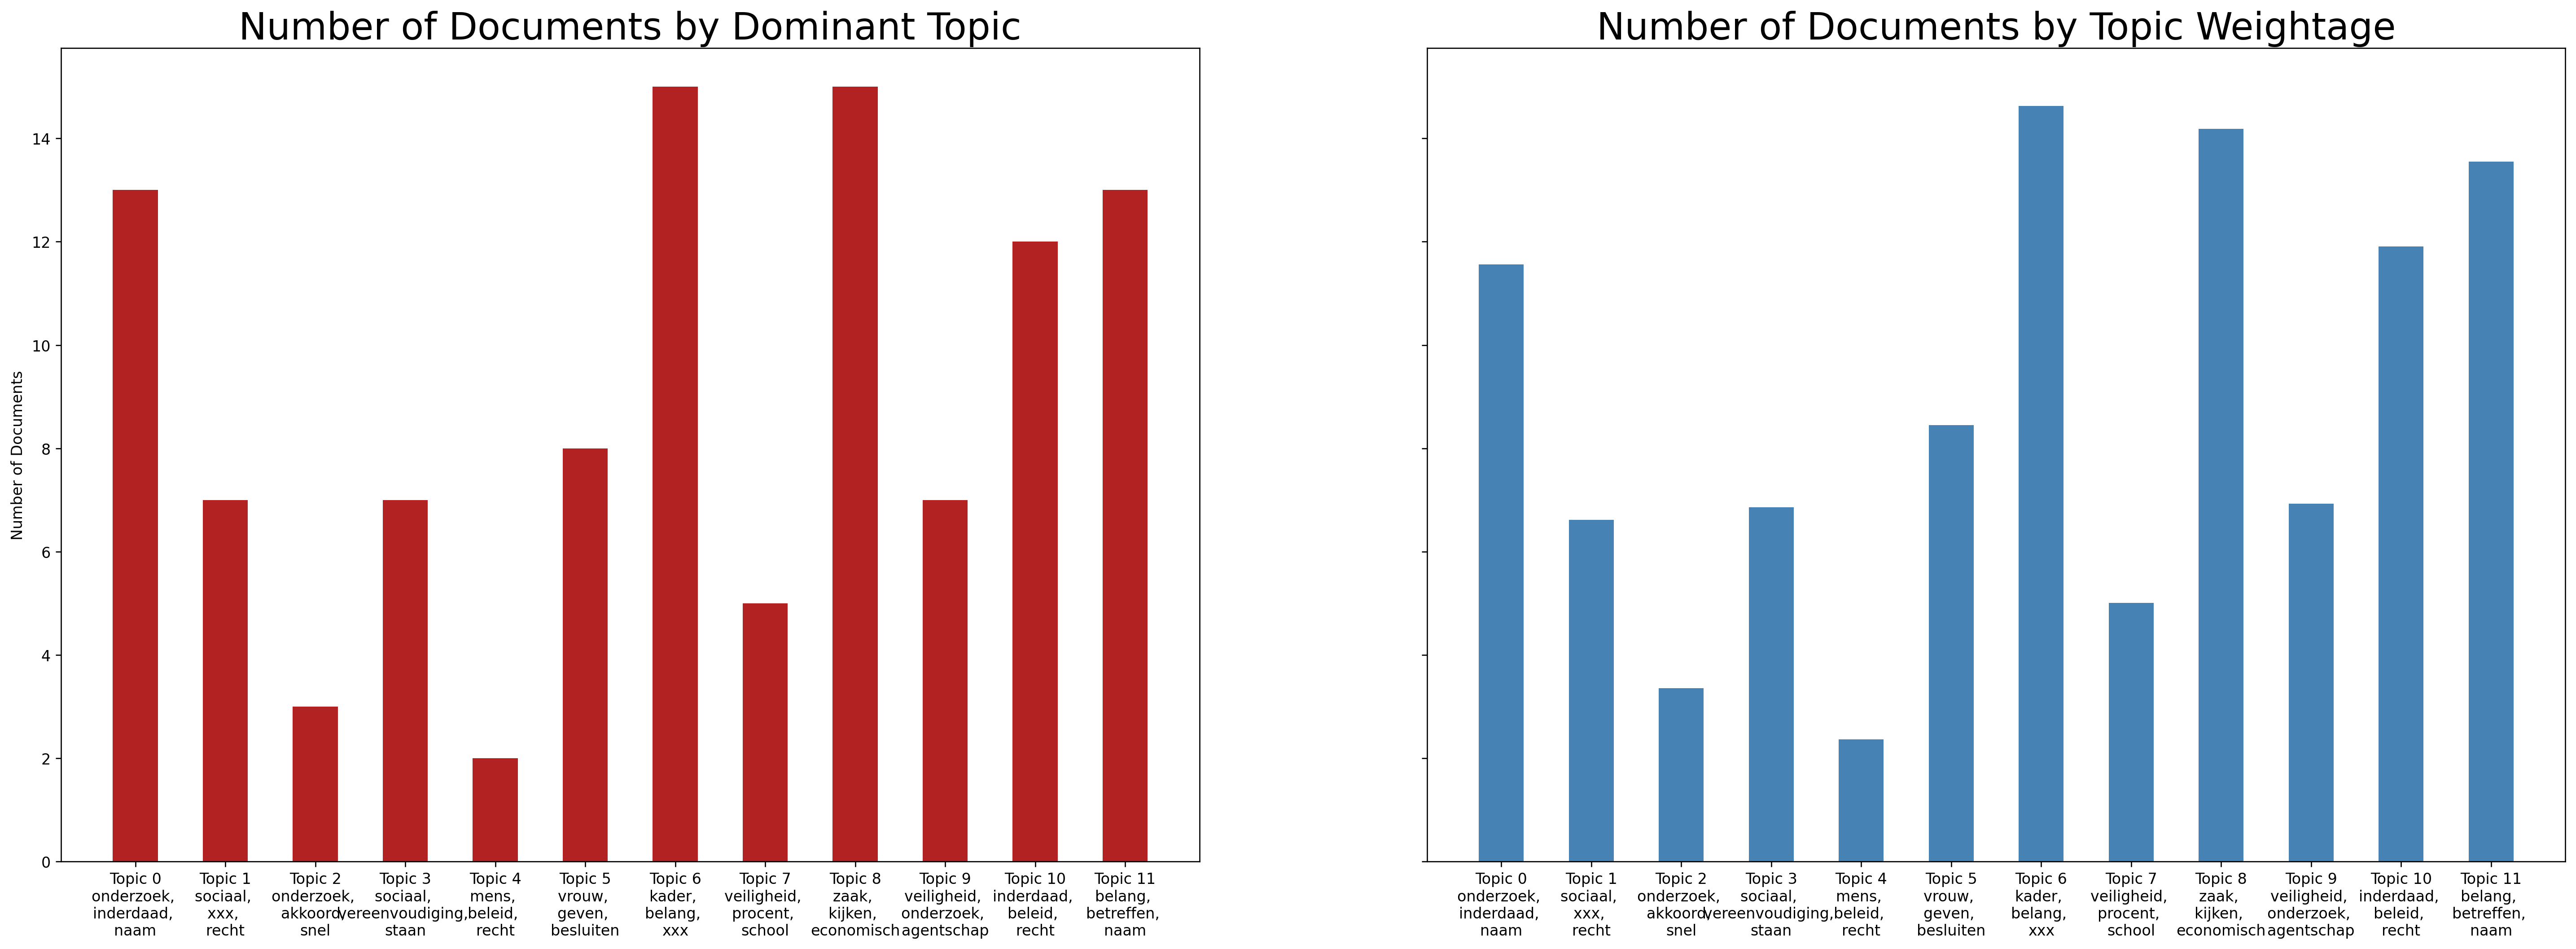

In [171]:
plottopicdocument(models[0],corpus)

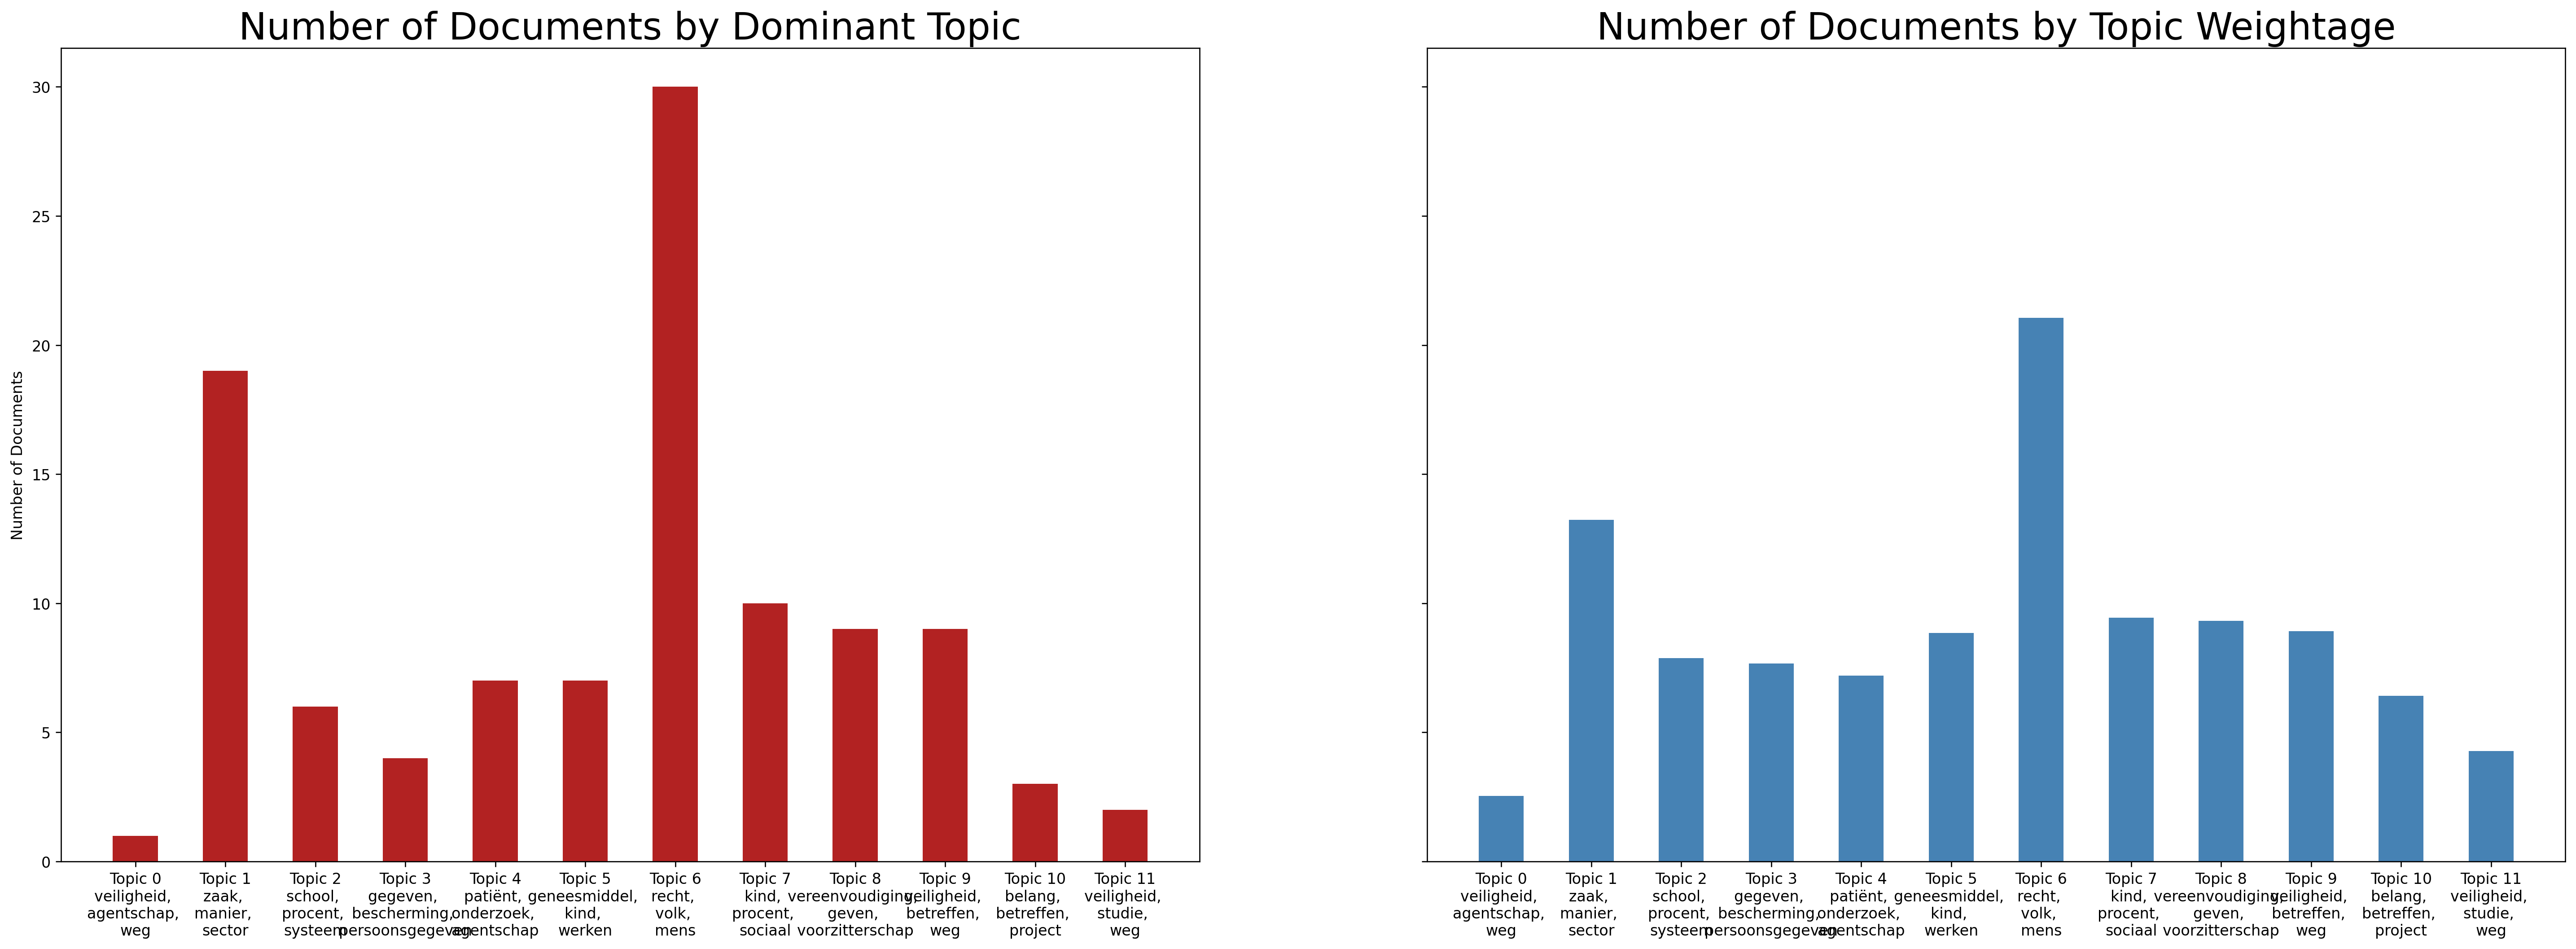

In [172]:
plottopicdocument(models[1],corpus)

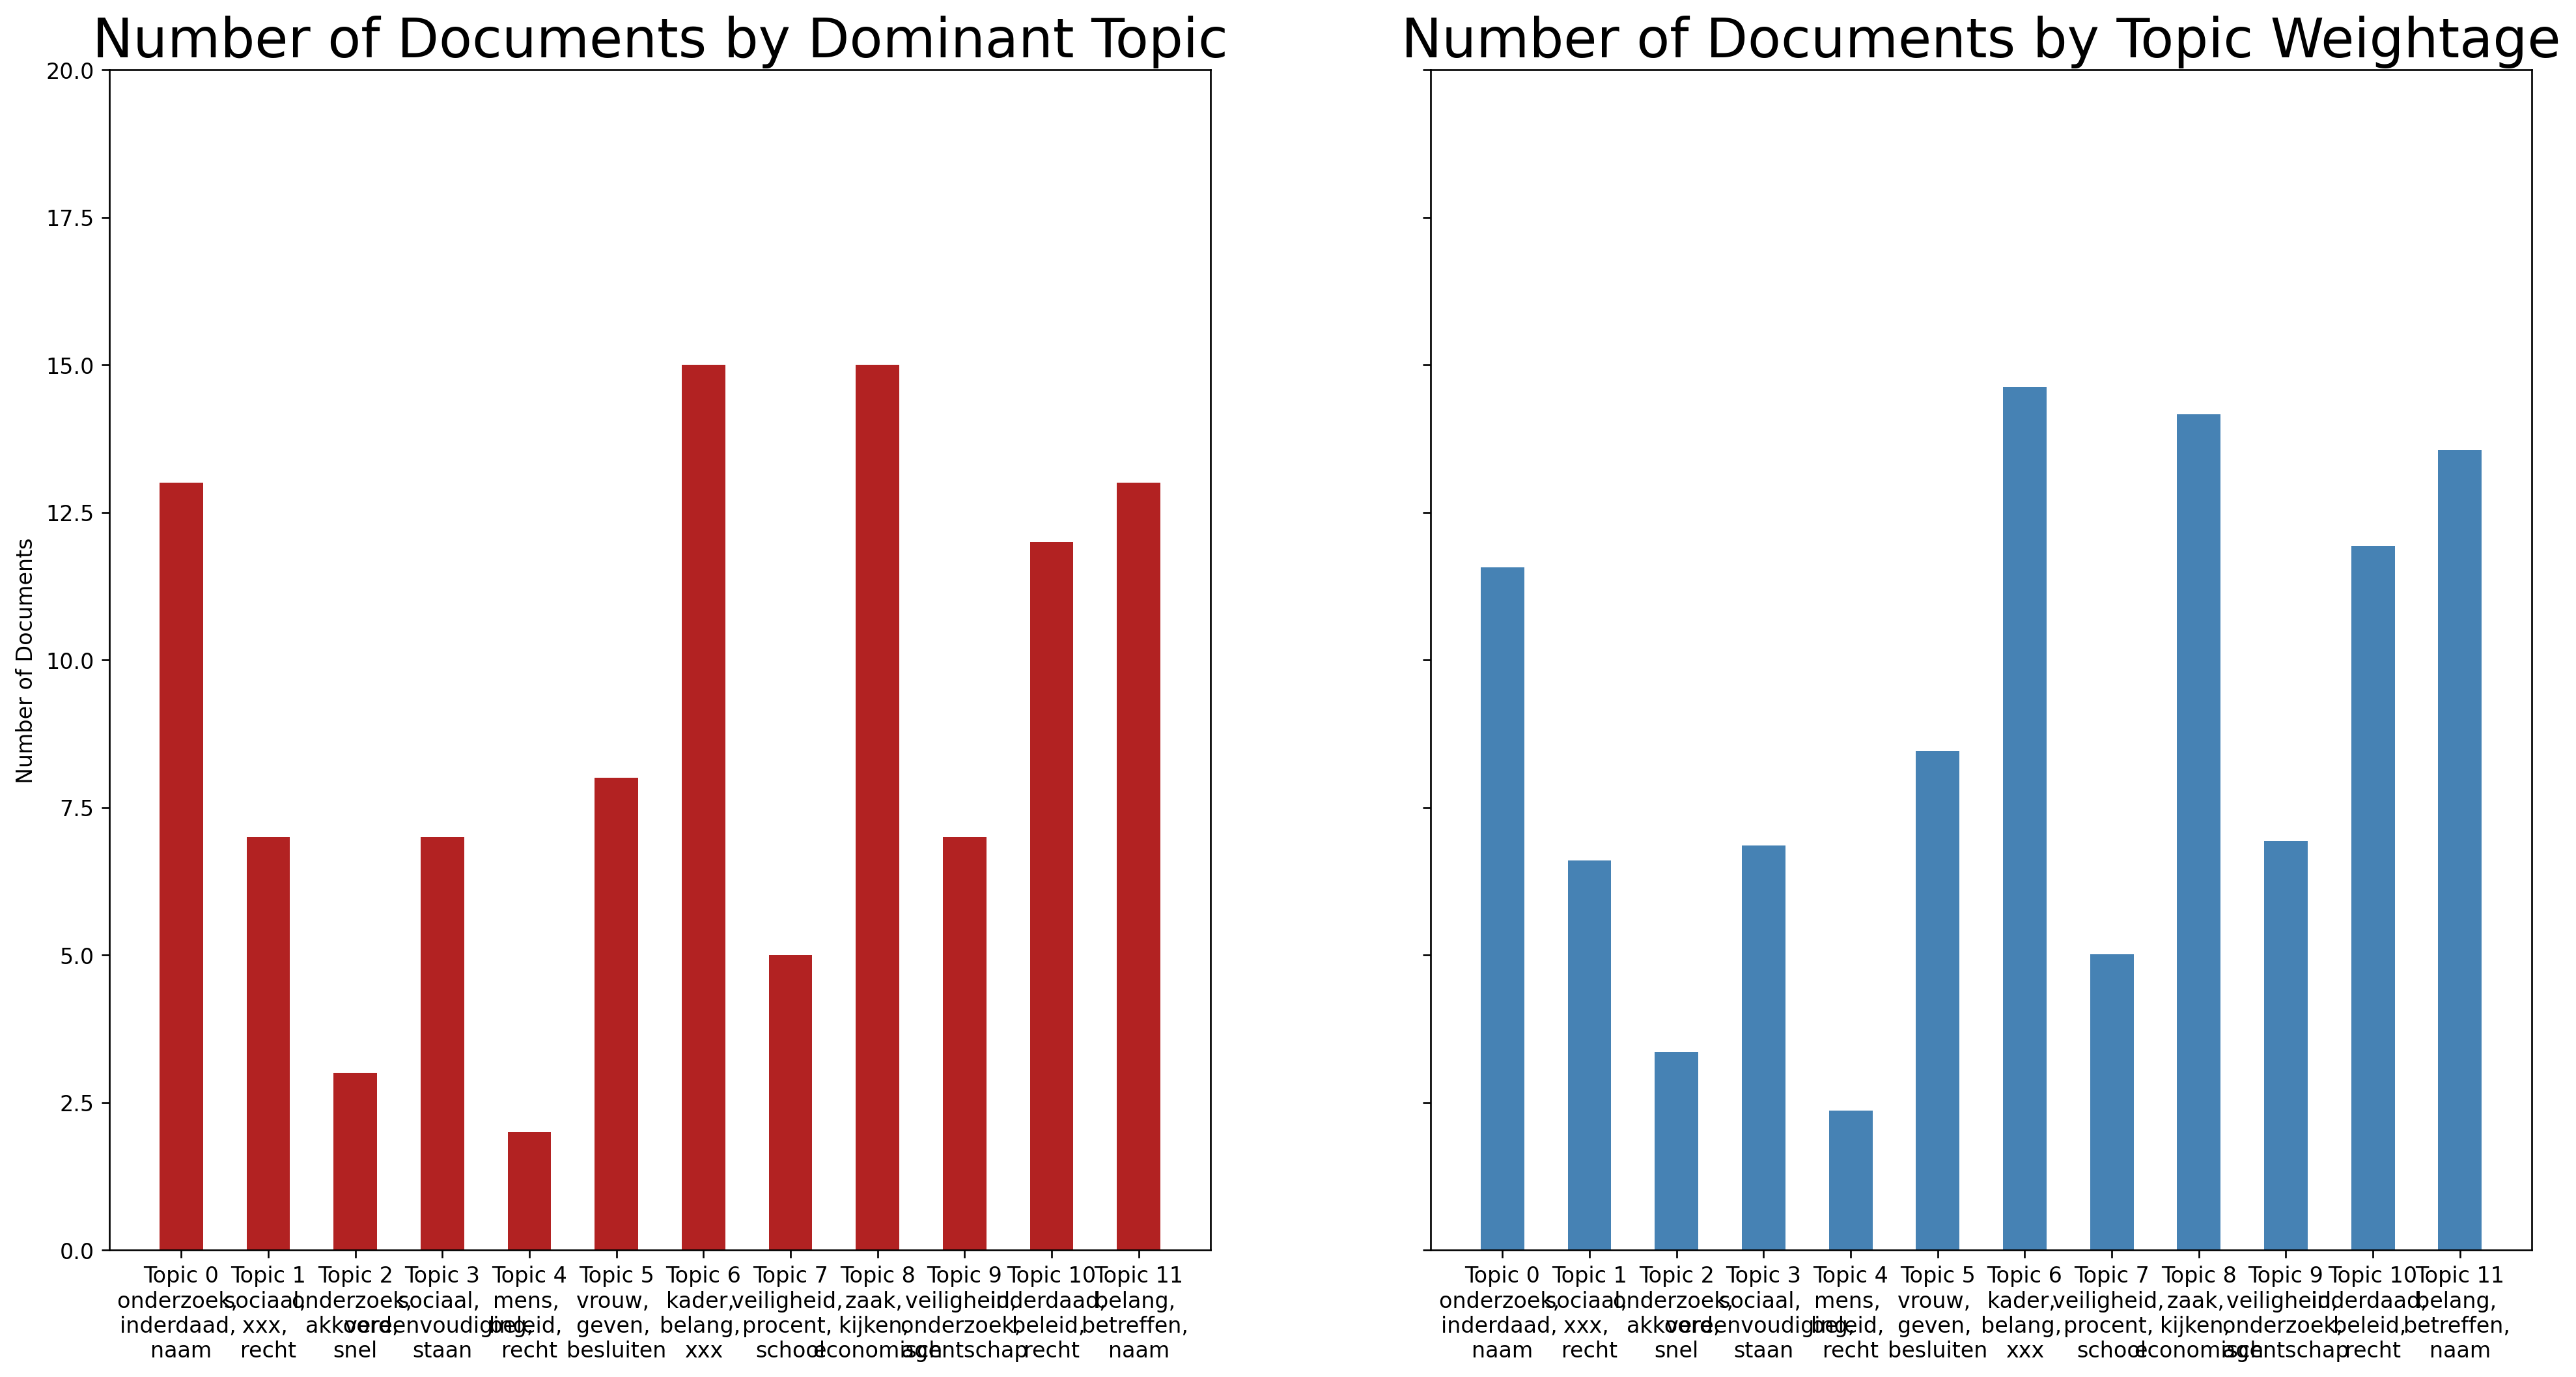

In [156]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=240, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=25))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=25))

plt.show()

In [329]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    tw = [0]*10
    for j,p in row_list:
        tw[j] = p
    topic_weights.append(tw)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.658743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.575775
[t-SNE] KL divergence after 1000 iterations: 0.124925


Loading BokehJS ...

In [313]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [324]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    print(i)
    print(row_list)
    tw = [0]*10
    for j,p in row_list:
        tw[j] = p
    topic_weights.append(tw)

0
[(3, 0.9624822)]
1
[(3, 0.7744933), (8, 0.22053435)]
2
[(5, 0.98199165)]
3
[(3, 0.9590789)]
4
[(4, 0.9874966)]
5
[(4, 0.96665305)]
6
[(4, 0.9852406)]
7
[(0, 0.91524476), (9, 0.07224879)]
8
[(3, 0.177847), (4, 0.036474973), (9, 0.7831568)]
9
[(3, 0.9854795)]
10
[(9, 0.9956281)]
11
[(6, 0.99188805)]
12
[(6, 0.9911732)]
13
[(6, 0.99447554)]
14
[(6, 0.3312342), (9, 0.6628786)]
15
[(4, 0.9937897)]
16
[(7, 0.98332864)]
17
[(2, 0.9911714)]
18
[(7, 0.94704396)]
19
[(0, 0.88292783), (8, 0.1056353)]
20
[(6, 0.6504689), (9, 0.3382553)]
21
[(2, 0.9608585)]
22
[(7, 0.9799949)]
23
[(3, 0.59028393), (6, 0.40346202)]
24
[(9, 0.9908137)]
25
[(1, 0.64889485), (2, 0.017842757), (8, 0.33013234)]
26
[(8, 0.989152)]
27
[(6, 0.97186726)]
28
[(0, 0.051838245), (3, 0.15069155), (5, 0.6951913), (6, 0.10088128)]
29
[(4, 0.97623044), (6, 0.01824612)]
30
[(9, 0.99099666)]
31
[(0, 0.7202202), (7, 0.27236375)]
32
[(2, 0.994075)]
33
[(8, 0.94373447)]
34
[(9, 0.9852364)]
35
[(1, 0.16134231), (6, 0.83204067)]
36
[(0,

In [325]:
arr = pd.DataFrame(topic_weights).fillna(0).values

In [327]:
arr[0]

array([0.        , 0.        , 0.        , 0.96248221, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [323]:
[0]*9

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [349]:
num_topics = 10
toR = pd.DataFrame()
toR['x_tsne'] = tsne_lda[:,0]
toR['y_tsne'] = tsne_lda[:,1]
toR['x_1_topic_probability'] = np.amax(arr, axis=1)
for t in range(num_topics):
    name = 'topic' + str(t+1)
    toR[name] = arr[:,t]

toR.to_csv("toR.csv",sep=";")

In [346]:
toR

x_tsne     y_tsne  x_1_topic_probability    topic1  topic2  topic3  \
0   -5.142224  -5.101617               0.962482  0.000000     0.0     0.0   
1   -5.605696  -5.010653               0.774311  0.000000     0.0     0.0   
2   -6.457727 -11.575111               0.981992  0.000000     0.0     0.0   
3   -5.245126  -4.786761               0.959079  0.000000     0.0     0.0   
4   -0.622163  -7.438326               0.987497  0.000000     0.0     0.0   
..        ...        ...                    ...       ...     ...     ...   
103 -0.539775  -8.011682               0.990319  0.000000     0.0     0.0   
104 -9.565274  -7.138627               0.986761  0.000000     0.0     0.0   
105 -6.468329  -0.745067               0.970456  0.000000     0.0     0.0   
106 -5.942807  -0.798621               0.982347  0.000000     0.0     0.0   
107 -3.878039 -10.357382               0.990422  0.990422     0.0     0.0   

       topic4    topic5  
0    0.962482  0.000000  
1    0.774311  0.000000  
2    0.000000  0.000000  
3    0.959079  0.000000  
4    0.000000  0.987497  
..        ...       ...  
103  0.000000  0.990319  
104  0.000000  0.000000  
105  0.000000  0.000000  
106  0.000000  0.000000  
107  0.000000  0.000000  

[108 rows x 8 columns]

In [179]:
overview(num_freq_stopwords=50)

The number of topics is 10.
Tokens with the 50 highest document frequency are added to the stopwords and removed from the corpus.
All the selected tokens have a minimum length of 2.
The descriptive statistics of the processed data is shown below.
The tokens with the highest document frequence are
['twee']
['zien']
['europa', 'krijgen']
['commissaris', 'collega']
['land', 'unie']
['waar']
['jaar']
['groot', 'denken']
['zoals', 'ander', 'alleen']
['lidstaat']
['nodig', 'belangrijk']
['mevrouw', 'raad', 'zorgen']
['rapporteur', 'tussen', 'burger', 'natuurlijk', 'heer']
['vinden', 'vragen', 'punt', 'aantal', 'danken']
['weten', 'duidelijk', 'echt']
['laten', 'financieel']
['werk', 'stellen', 'nieuw', 'voorstel', 'xxx']
['mogelijk', 'verslag', 'europese', 'nemen']
['beleid', 'geven']
['kijken', 'belang', 'inderdaad', 'staan', 'zaak']
['blijven', 'akkoord', 'feit', 'volgen', 'naam', 'politiek', 'zeer', 'zodat']
['houden', 'recht', 'verband', 'ver', 'werken', 'namelijk', 'kader', 'markt', 'be

In [185]:
data = pre_processing('Dutch.csv',min_len=2,notags=False,num_freq_stopwords=50) 
corpus = data[1]
id2word = data[0] 
input_tokens = data[2]
models = createmodels(id2word,corpus,num_topics=12)

In [277]:
models11 = createmodels(id2word,corpus,num_topics=11)

In [197]:
models2 = createmodels(id2word,corpus,num_topics=6)

In [200]:
data_fr = pre_processing('French.csv',min_len=2,notags=False,num_freq_stopwords=50,language='FR') 
corpus_fr = data_fr[1]
id2word_fr = data_fr[0] 
input_tokens_fr = data_fr[2]
models_fr = createmodels(id2word_fr,corpus_fr,num_topics=12)

with 1 most frequent tokens removed


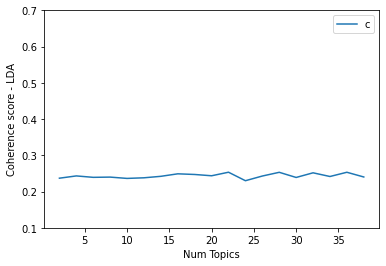

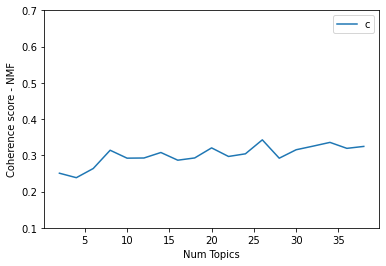

with 20 most frequent tokens removed


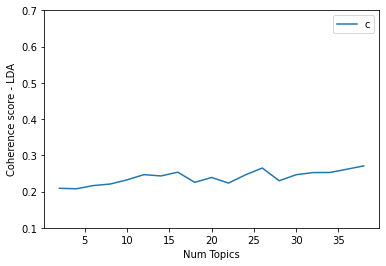

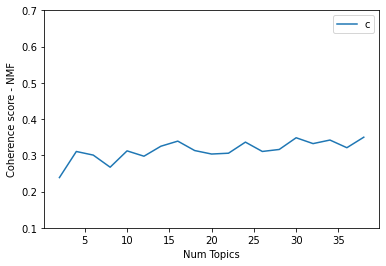

with 40 most frequent tokens removed


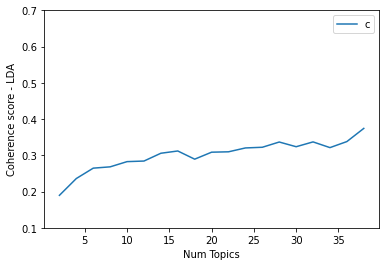

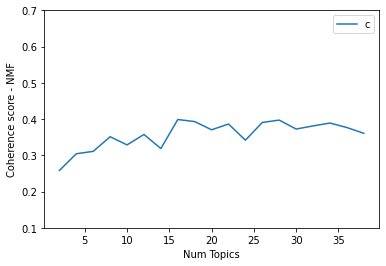

with 50 most frequent tokens removed


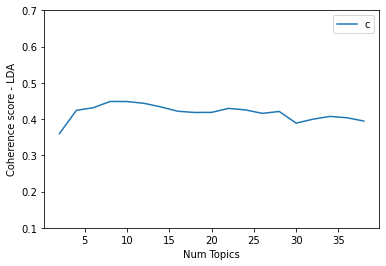

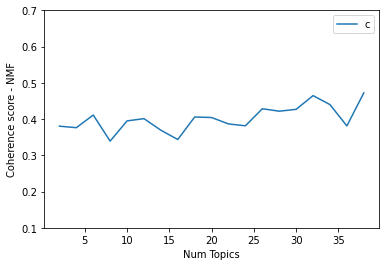

with 60 most frequent tokens removed


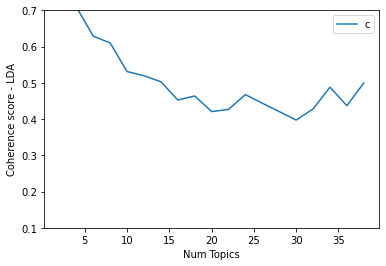

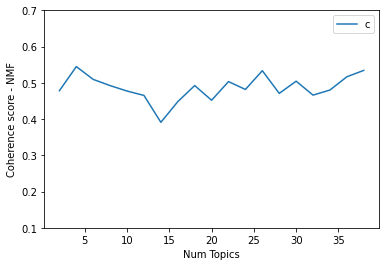

In [173]:
for num_freq_stopwords in [1,20,40,50,60]:
    data = pre_processing('Dutch.csv',min_len=1,notags=False,num_freq_stopwords=num_freq_stopwords) 
    corpus = data[1]
    id2word = data[0] 
    input_tokens = data[2]
    print(f'with {num_freq_stopwords} most frequent tokens removed')
    compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)


with 1 most frequent tokens removed


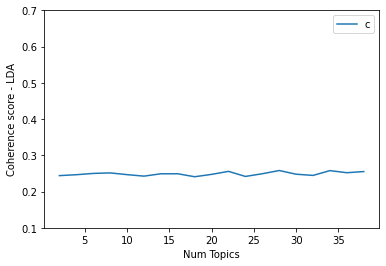

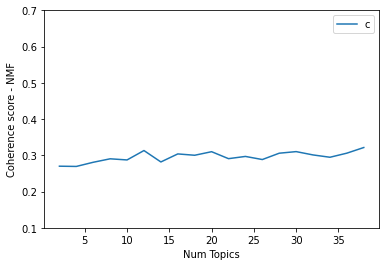

with 20 most frequent tokens removed


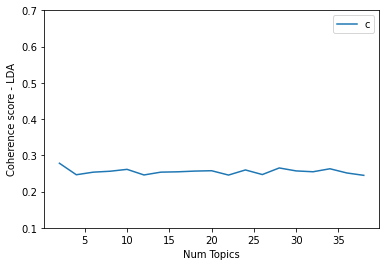

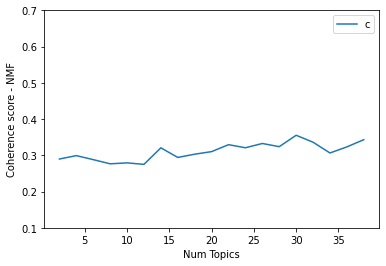

with 40 most frequent tokens removed


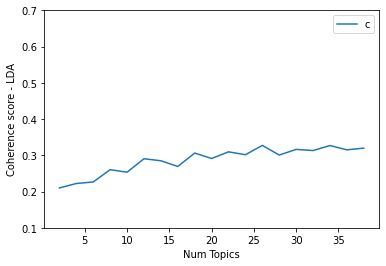

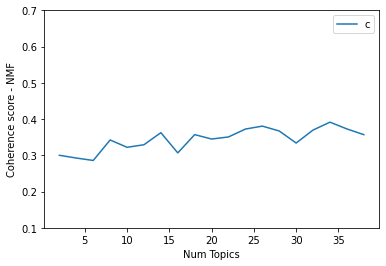

with 50 most frequent tokens removed


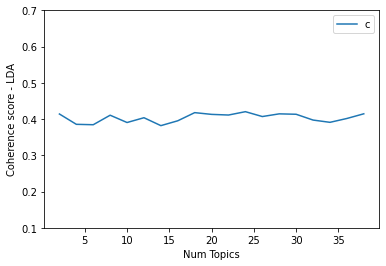

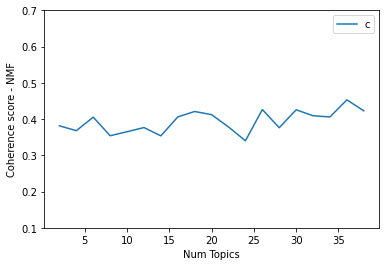

with 60 most frequent tokens removed


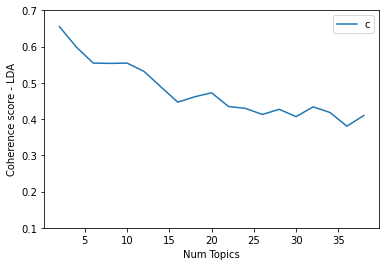

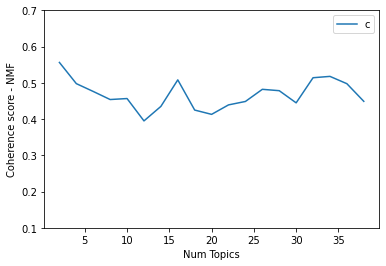

In [174]:
for num_freq_stopwords in [1,20,40,50,60]:
    data = pre_processing('French.csv',min_len=1,notags=False,num_freq_stopwords=num_freq_stopwords,language='FR') 
    corpus = data[1]
    id2word = data[0] 
    input_tokens = data[2]
    print(f'with {num_freq_stopwords} most frequent tokens removed')
    compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)

with 40 most frequent tokens removed


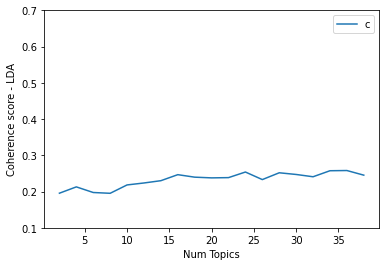

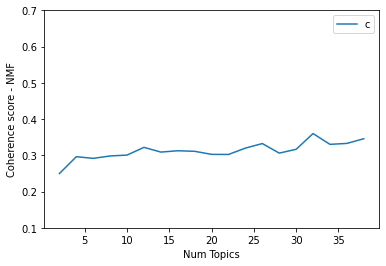

In [175]:
num_freq_stopwords = 40
data = pre_processing('Dutch.csv',min_len=1,notags=True,num_freq_stopwords=num_freq_stopwords) 
corpus = data[1]
id2word = data[0] 
input_tokens = data[2]
print(f'with {num_freq_stopwords} most frequent tokens removed')
compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)


with 50 most frequent tokens removed


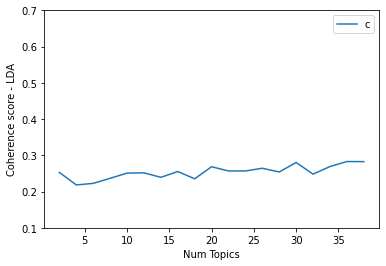

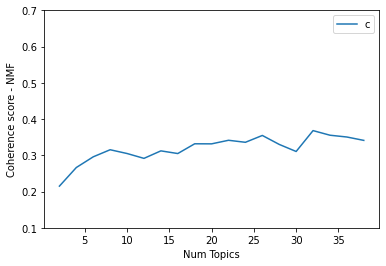

In [176]:
num_freq_stopwords = 50
data = pre_processing('Dutch.csv',min_len=1,notags=True,num_freq_stopwords=num_freq_stopwords) 
corpus = data[1]
id2word = data[0] 
input_tokens = data[2]
print(f'with {num_freq_stopwords} most frequent tokens removed')
compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)

with 50 most frequent tokens removed


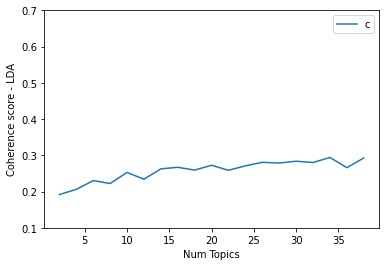

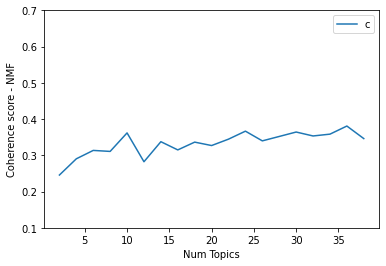

In [177]:
num_freq_stopwords = 50
data = pre_processing('French.csv',min_len=1,notags=True,num_freq_stopwords=num_freq_stopwords,language='FR') 
corpus = data[1]
id2word = data[0] 
input_tokens = data[2]
print(f'with {num_freq_stopwords} most frequent tokens removed')
compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)

with 40 most frequent tokens removed


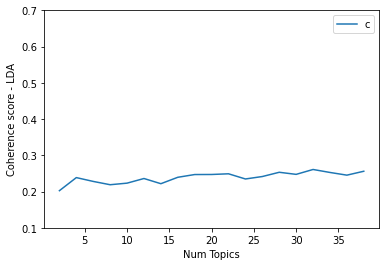

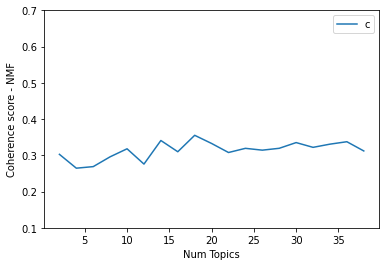

In [178]:
num_freq_stopwords = 40
data = pre_processing('French.csv',min_len=1,notags=True,num_freq_stopwords=num_freq_stopwords,language='FR') 
corpus = data[1]
id2word = data[0] 
input_tokens = data[2]
print(f'with {num_freq_stopwords} most frequent tokens removed')
compute_coherence_values(dictionary=id2word, corpus=corpus, texts=input_tokens, limit=40, start=2, step=2)

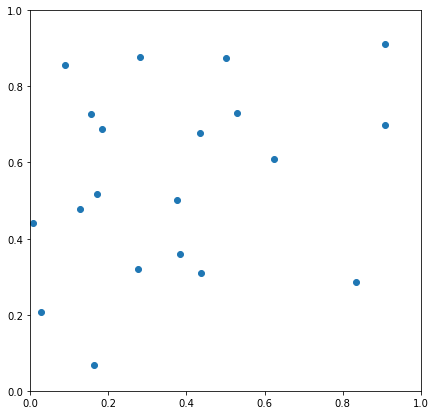

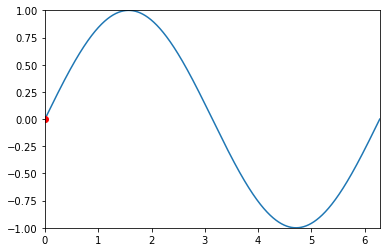

In [209]:
source = ColumnDataSource(data=dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    names=list(range(108))))





labels = LabelSet(x='x', y='y', text='names', 
              x_offset=5, y_offset=5, source=source, render_mode='canvas')
    


In [279]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, Scatter


model = models[0]
topic_weights = []
num_topics = model.num_topics
for i, row_list in enumerate(model[corpus]):
    tw = [0]*num_topics
    for j,p in row_list:
        tw[j] = p
    topic_weights.append(tw)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)




def createtsne(model,corpus):
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0]*num_topics
        for j,p in row_list:
            tw[j] = p
        topic_weights.append(tw)

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    #arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_outcome = tsne_model.fit_transform(arr)
    
    return tsne_outcome, topic_num


tsne0 = createtsne(models[0],corpus)[0]
tsne1 = createtsne(models11[0],corpus)[0]

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])


source = ColumnDataSource(data=dict(
    x0=tsne0[:,0],
    y0=tsne0[:,1],
    x1=tsne1[:,0],
    y1=tsne1[:,1],
    x=tsne0[:,0],
    y=tsne0[:,1],
    colour=mycolors[topic_num%10],
    names=list(range(108))))
# Plot the Topic Clusters using Bokeh
#output_notebook()
n_topics = num_topics

mycolors2 = np.array([name for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} Topics".format(n_topics), 
              plot_width=900, plot_height=700)



#glyph = Scatter(x="x", y="y")
#plot.add_glyph(source, glyph)
plot.scatter(x='x', y='y', source=source, color='colour',size=20)




labels = LabelSet(x='x', y='y', text='names', 
              x_offset=5, y_offset=5, source=source, render_mode='canvas')
slider = Slider(start=0, end=1, value=0, step=.1, title="power")


update_curve = CustomJS(args=dict(source=source, slider=slider), code="""
    var data = source.data;
    var f = slider.value;
    var x = data['x']
    var y = data['y']
    var x0 = data['x0']
    var y0 = data['y0']
    var x1 = data['x1']
    var y1 = data['y1']
    for (var i = 0; i < x.length; i++) {
        y[i] = f*y0[i] + (1-f)*y1[i]
        x[i] = f*x0[i] + (1-f)*x1[i]
        
    }
    
    // necessary becasue we mutated source.data in-place
    source.change.emit();
""")
slider.js_on_change('value', update_curve)

plot.add_layout(labels)



show(column(slider, plot))
    

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.713224
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.694252
[t-SNE] KL divergence after 800 iterations: 0.114534
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.713261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.954903
[t-SNE] KL divergence after 750 iterations: 0.112612
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.722474
[t-SNE] KL divergence after 250 iterations

In [252]:
topic_num

array([ 3,  9, 11,  6,  9,  9,  1,  0,  0,  0,  0,  1,  4,  9,  3,  6,  3,
        1,  5,  9,  3,  7,  9,  5,  1, 11, 10, 10, 11, 11, 10,  6,  8,  2,
        2,  8,  9,  1,  1,  1, 10, 11,  7,  4, 11, 11,  3, 10,  3,  6,  6,
        5,  5,  3,  2,  6,  7,  9,  7,  4,  2,  5,  4, 10, 10,  7,  0, 11,
        3,  8,  8,  4, 11,  3, 10,  4,  6,  1,  0,  1,  5,  3,  4,  3,  8,
        0,  1,  1,  3,  0,  1,  0,  9,  9, 10,  4,  8,  4, 11, 11,  3,  1,
        9,  2,  5,  2,  2, 11], dtype=int64)

In [273]:
NL['0'][10]

"voorzitter beste collega's wij moeten nu een verslag behandelen dat voor de eerste keer ook een euh politieke dimensie krijgt . wij hebben debatten gehad over het referendum in tweeduizend vijf in verband met de ratificatie van het constitutioneel verdrag en het euh idee van een euh vrije mededingingsruimte een open mededingingsruimte zoals het nu euh zoals het nu wordt genoemd en zoals het had gestaan in euh de grondwet als die was goedgekeurd en dat euh stond ook centraal in de discussie . nu is het euh de bedoeling dat wij laten zien dat het mededingingsbeleid in dienst kan staan van de bevolking in dienst moet staan van de bevolking en dat is ook al zo . in euh dit verband bestaat er een grote overeenstemming bij de Commissie maar ik euh moest dan als rapporteur ingaan op duidelijke gevallen duidelijke gevallen waarbij een n nieuwe oriëntatie of een nieuw onderzoek nodig was van het mededingingsbeleid of in euh waarbij men vooral het mededingingsbeleid sterk aanmoedigde euh als er

In [274]:
NL['0'][59]

"beste collega's ik ben nog eens euh verheugd om de wijziging van de rechtsgrondslag voor het stabiliteitsinstrument en ik wil euh de Commissie en de Raad ook danken voor het goedkeuren van die wijziging en ook euh is het goed dat euh inderdaad het toepassingsveld is euh vastgelegd voor het stabiliteitsinstrument met haar . het gaat nu dus over het handhaven van de vrede en de bestrijding van het terrorisme maar ik denk wel dat een Kolbachmecanisme dat niet dwingend euh zou zijn niet voldoende is om te voldoen aan de tekortkomingen van de inspraak van het Parlement en verder euh denk ik dat het goed is dat het Parlement niet heeft toegegeven aan euh de Raad en de Commissie . we gaan morgen stemmen over een tekst waarin de bevoegdheden van het Parlement worden vastgelegd zoals euh medewetgeving dus om de oriëntaties te kunnen meegeven voor euh de nieuwe euh ontwikkelings euh instrumenten en deze politieke oriëntatie waar wij medebeslissing voor wensen dat zal een vervanging zijn van de 

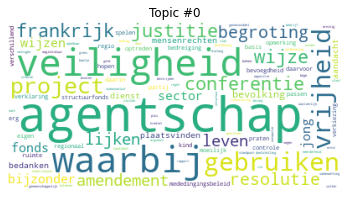

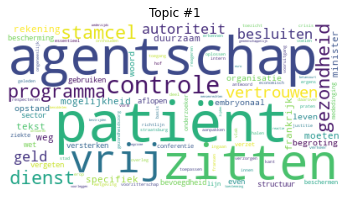

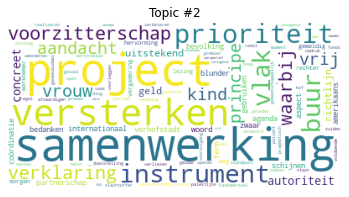

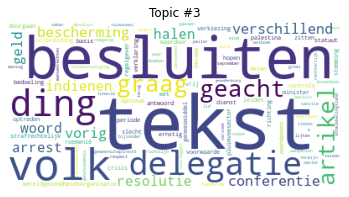

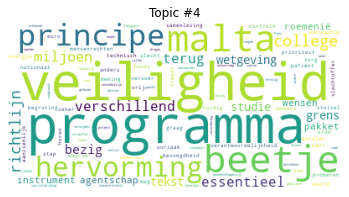

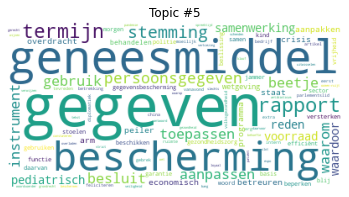

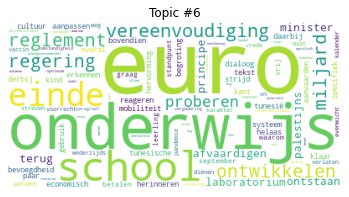

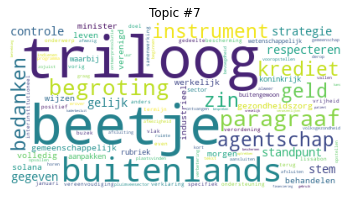

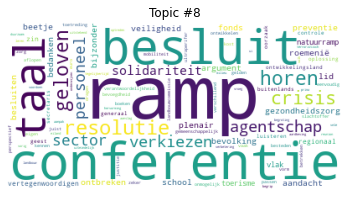

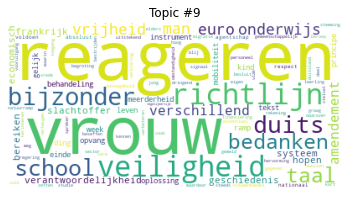

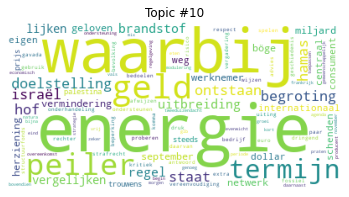

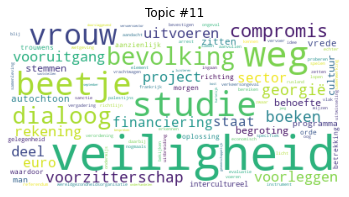

In [276]:
plotwordcloud(models[0])